# Contents

In [1]:
library(tmvtnorm)
library(ggplot2)
library(ggExtra)
library(brms)
library(reshape2)
library(coda)
library(mefa)
library(tidybayes)
library(ggstance)
library(viridis)
library(latex2exp)
library(ggthemes)
library(data.table)
library(bayesplot)
library(diptest)

# data_path = "../data/choices_processed.txt"
data_path = "C:/Users/Arkady/Google Drive/data/beyond_the_reach"
figure_path = "C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/figures"
table_path = "C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/tables"

figure_format = "png"

Loading required package: mvtnorm
Loading required package: Matrix
Loading required package: stats4
Loading required package: gmm
Loading required package: sandwich
Warning message:
"package 'ggplot2' was built under R version 3.5.2"Loading required package: Rcpp
Loading 'brms' package (version 2.4.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.
Warning message:
"package 'reshape2' was built under R version 3.5.2"mefa 3.2-7 	 2016-01-11

Attaching package: 'mefa'

The following object is masked from 'package:reshape2':

    melt

NOTE: As of tidybayes version 1.0, several functions, arguments, and output column names
      have undergone significant name changes in order to adopt a unified naming scheme.
      See help('tidybayes-deprecated') for more information.


Attaching package: 'ggstance'

The following object

Load processed data

In [2]:
get_processed_data <- function(data_path){
    filename <- file.path(data_path, "choices_processed.txt")
    data <- read.table(filename, header = TRUE, sep = ",")
    data[, "subj_id"] <- as.factor(data[, "subj_id"])
    data[, "option_chosen"] <- as.factor(data[, "option_chosen"])
    
    return(data)
}

In [3]:
data <- get_processed_data(data_path)
mouse_data <- data[data$task=="mouse",]
walking_data <- data[data$task=="walking",]

# Checking for max-d unimodality<a class="anchor" id="com"></a>

Checking for unimodality of the max-d distributions

In [4]:
print(dip.test(mouse_data$max_d, simulate.p.value = TRUE))
print(dip.test(walking_data$max_d, simulate.p.value = TRUE))


	Hartigans' dip test for unimodality / multimodality with simulated
	p-value (based on 2000 replicates)

data:  mouse_data$max_d
D = 0.0052932, p-value = 0.9605
alternative hypothesis: non-unimodal, i.e., at least bimodal


	Hartigans' dip test for unimodality / multimodality with simulated
	p-value (based on 2000 replicates)

data:  walking_data$max_d
D = 0.0061884, p-value = 0.8345
alternative hypothesis: non-unimodal, i.e., at least bimodal



Hartigans' dip test doesn't provide evidence in favor of multimodality. Still, the histograms of max-d for the walking task reveal that there are at least two distinct clusters of trajectories. For this reason, we check the robustness of the max-d analysis using a subset of trajectories which exclude changes-of-mind (CoM; see preprocessing notebook for a criterion used to detect CoMs)

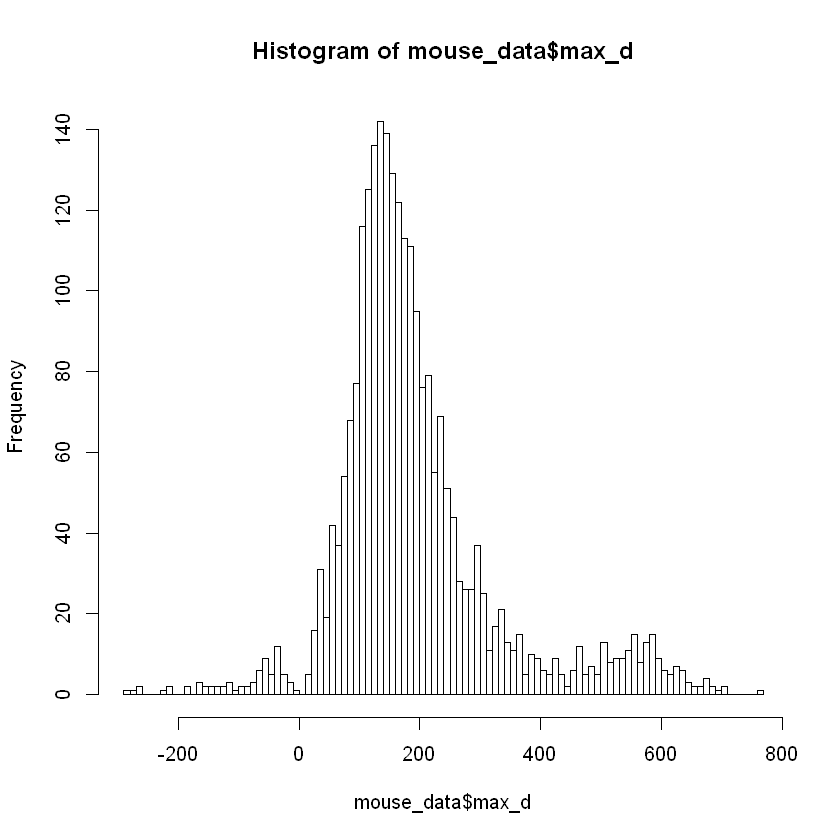

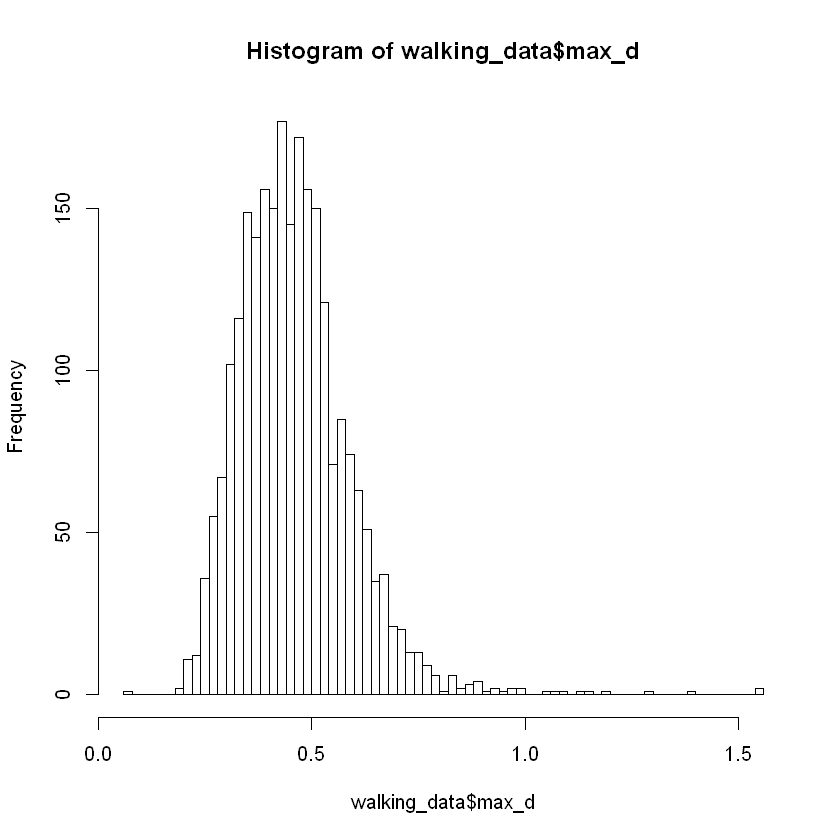

In [5]:
hist(mouse_data$max_d, breaks = 100, freq = TRUE)
hist(walking_data$max_d, breaks = 100, freq = TRUE)

In [6]:
mouse_data_no_com <- mouse_data[mouse_data$is_com=="False",]
walking_data_no_com <- walking_data[walking_data$is_com=="False",]

# Functions for model fitting and BF calculation

In [13]:
get_bf_dyn <- function(data, formulas, prior, n){ 
    " This function fits three models to the supplied data and returns the fitted models and averaged BFs over 10 runs"
#     models <- list(m_inter = NULL, m_choice = NULL, m_null = NULL)
#     m_inter <- fit_model(models$m_inter, data, formulas$f_inter, prior)
#     m_choice <- fit_model(models$m_choice, data, formulas$f_choice, prior[1,])
#     m_null <- fit_model(models$m_null, data, formulas$f_null, prior[1,])    
    m_inter <- brm(formulas$f_inter, data = data, family = gaussian(), save_all_pars = TRUE,
                   control = list(adapt_delta = 0.99), prior = prior, refresh = 0)
    m_choice <- brm(formulas$f_choice, data = data, family = gaussian(), save_all_pars = TRUE,
                   control = list(adapt_delta = 0.99), prior = prior[1:2,], refresh = 0)
    m_null <- brm(formulas$f_null, data = data, family = gaussian(), save_all_pars = TRUE,
                   control = list(adapt_delta = 0.99), prior = prior[1,], refresh = 0)
    bfs <- data.frame(double(), double(), double())
    
    for (i in 1:n) {
        bfs <- rbind(bfs, t(c(bayes_factor(x1 = m_choice, x2 = m_null)$bf,
                              bayes_factor(x1 = m_inter, x2 = m_null)$bf,
                              bayes_factor(x1 = m_inter, x2 = m_choice)$bf)))
    }
    
    colnames(bfs) <- c('bf_task', 'bf_session', 'bf_inter')
    
    ci_inter <- HPDinterval(as.mcmc(m_inter, combine_chains = TRUE))
    
    result = list(bf=colMeans(bfs),
                  models = list(m_null = m_null, 
                                m_choice = m_choice, 
                                m_inter = m_inter), 
                  ci_inter = ci_inter)
    
    return(result)
}

# fit_model <- function(model, data, formula, prior){
#     " This function updates the brms model if it exists (to avoid slow recompilation of the C++ model by Stan), 
#     or creates a model from scratch if it doesn't exist yet "
#     if(!is.null(model)){
#         model <- update(model, newdata = data, recompile = FALSE)        
#     } else {
#         model <- brm(formula, data = data, family = gaussian(), save_all_pars = TRUE,
#                    control = list(adapt_delta = 0.99), prior = prior, refresh = 0)
#     }
#     return(model)
# }

run_analysis <- function(dv, iv, data, rscale, n_bf=10){
    " This function runs our analysis for a given dataset (fake or real) and given dependent and 
    independent variables (dv and iv); rscale parameter defines the scale of prior distribution 
    on regression slopes (see Rouder & Morey (2012))"    
    interaction_term = paste(iv, "option_chosen", sep=':')
    formulas <- list(f_inter = as.formula(paste(dv, "~ (option_chosen | subj_id) + option_chosen +", interaction_term)),
                     f_choice = as.formula(paste(dv, "~ (option_chosen | subj_id) + option_chosen")),
                     f_null = as.formula(paste(dv, "~ (1 | subj_id)")))

    " Priors on centered intercepts are the values of DV when all predictors are at their means (see brms docs).
    brms accepts priors on non-standardized b coefficients. We compute them by scaling default priors on standardized 
    coefficients (Rouder & Morey, 2012) to sd(DV)/sd(IV)"
    prior <- c(set_prior(sprintf('normal(%f, %f)', mean(data[, dv]), sd(data[, dv])), class = "Intercept"), 
           set_prior(sprintf('cauchy(0, %f)', rscale*sd(data[, dv])/0.5), class="b", coef = "option_chosenss"),
           set_prior(sprintf('cauchy(0, %f)', rscale*sd(data[, dv])/sd(data[, iv])), class = "b"))

    bf_result <- get_bf_dyn(data, formulas, prior, n=n_bf)
    
    analysis_id <- paste(dv, iv, deparse(substitute(data)))
    
    bf_result$analysis_id <- analysis_id    
    print_bf(bf_result, iv)
    
    return(bf_result)
}

# Functions for visualizing and saving the results

In [14]:
print_bf <- function(bf_result, iv="Delta"){
    print(bf_result$analysis_id)
    print(sprintf("BF of choice model over null model: %g", bf_result$bf[1]))
    print(sprintf("BF of choice-by-delta model over null model: %g", bf_result$bf[2]))
    print(sprintf("BF of choice-by-delta model over choice-only model: %g", bf_result$bf[3]))
    
    print(bf_result$ci[c(paste("b_option_chosenll:", iv, sep=""), 
                         paste("b_option_chosenss:", iv, sep=""),
                         "b_option_chosenss"),]) 
}

spaghetti_plot <- function(model, data, dv, iv, task, figure_format){
    file_name=sprintf("spaghetti_%s_%s.%s", task, dv, figure_format)
    plt <- plot(marginal_effects(model, spaghetti=TRUE, nsamples=300, 
                                 effects=paste(iv, "option_chosen", sep=":")), 
                plot=FALSE)[[1]]                                                                            
    plt <- plt + 
        geom_point(aes_string(x=iv, y=dv, shape='option_chosen', colour='option_chosen'), 
                   size = 3, alpha=0.1, data = data) +
        theme_pander(base_size = 24) +
        ggtitle(paste(task, gsub("_", "-", dv))) +
        theme(plot.title = element_text(hjust = 0.5, size=24, face="plain")) +
        xlab(TeX("$\\Delta$")) +
        ylab(gsub("_", "-", dv)) +
        theme(legend.position="none") +
        scale_color_viridis(discrete=TRUE, alpha=0.2, begin=0.0, end=0.7)
    if ((dv == 'RT') & (task == 'walking')){   
        plt <- plt + theme(legend.position = c(0.9, 0.9),
                      legend.title = element_blank(),
                      legend.text = element_text(size=24)) +
                guides(colour = guide_legend(override.aes=list(size = 8, linetype = 0, alpha = 1)))
    }
    ggsave(file.path(figure_path, file_name), dpi=300, width=4, height=4) 
}

save_posterior <- function(model, iv, file_name){    
    write.csv(as.matrix(as.mcmc(model, combine_chains=TRUE)), 
              file=file.path("posterior_csv", iv, file_name), row.names=FALSE)
}

visualize_result <- function(bf_result, data, task, dv, iv, figure_format){
    print_bf(bf_result, iv)
    spaghetti_plot(bf_result$models$m_inter, data, dv, iv, task, figure_format)
    save_posterior(bf_result$models$m_inter, iv, file_name = sprintf("posterior_%s_%s.%s", task, dv, "csv"))
}

# Functions for aggregating the results

In [15]:
save_all_plots <- function(results, iv){
    visualize_result(results$walking_max_d_bf, walking_data, "walking", "max_d", iv, figure_format)
    visualize_result(results$walking_rt_bf, walking_data, "walking", "RT", iv, figure_format)
    visualize_result(results$mouse_max_d_bf, mouse_data, "mouse", "max_d", iv, figure_format)
    visualize_result(results$mouse_rt_bf, mouse_data, "mouse", "RT", iv, figure_format)
    visualize_result(results$walking_max_d_no_com_bf, walking_data_no_com, 
                    "walking_no_com", "max_d", iv, figure_format)    
    visualize_result(results$walking_rt_no_com_bf, walking_data_no_com, 
                    "walking_no_com", "RT", iv, figure_format)    
    visualize_result(results$mouse_max_d_no_com_bf, mouse_data_no_com, 
                    "mouse_no_com", "max_d", iv, figure_format) 
    visualize_result(results$mouse_rt_no_com_bf, mouse_data_no_com, 
                    "mouse_no_com", "RT", iv, figure_format)
}

run_all_analyses <- function(iv, rscale){  
    walking_max_d_bf <- run_analysis("max_d", iv, walking_data, rscale)
    walking_rt_bf <- run_analysis("RT", iv, walking_data, rscale)
    mouse_max_d_bf <- run_analysis("max_d", iv, mouse_data, rscale)
    mouse_rt_bf <- run_analysis("RT", iv, mouse_data, rscale)

    walking_max_d_no_com_bf <- run_analysis("max_d", iv, walking_data_no_com, rscale)
    walking_rt_no_com_bf <- run_analysis("RT", iv, walking_data_no_com, rscale)
    mouse_max_d_no_com_bf <- run_analysis("max_d", iv, mouse_data_no_com, rscale)        
    mouse_rt_no_com_bf <- run_analysis("RT", iv, mouse_data_no_com, rscale)    
         
    return(list(walking_max_d_bf = walking_max_d_bf, walking_rt_bf = walking_rt_bf, 
                mouse_max_d_bf = mouse_max_d_bf, mouse_rt_bf = mouse_rt_bf,                 
                walking_max_d_no_com_bf = walking_max_d_no_com_bf, walking_rt_no_com_bf = walking_rt_no_com_bf,
                mouse_max_d_no_com_bf = mouse_max_d_no_com_bf, mouse_rt_no_com_bf = mouse_rt_no_com_bf))
}

# Run analyses (takes a lot of time!)

In [16]:
lambda_results <- run_all_analyses("Lambda", rscale=0.707)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 46.802 seconds (Warm-up)
               13.024 seconds (Sampling)
               59.826 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 44.955 seconds (Warm-up)
               23.252 seconds (Sampling)
               68.207 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.107 seconds (Warm-up)
               12.176 seconds (Sampling)
               42.283 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 45.93

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.744 seconds (Warm-up)
               11.44 seconds (Sampling)
               38.184 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 39.508 seconds (Warm-up)
               19.718 seconds (Sampling)
               59.226 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.139 seconds (Warm-up)
               12.187 seconds (Sampling)
               39.326 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.98 seconds (Warm-up)
               2.585 seconds (Sampling)
               9.565 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.656 seconds (Warm-up)
               2.369 seconds (Sampling)
               10.025 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.874 seconds (Warm-up)
               4.188 seconds (Sampling)
               12.062 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.898 seconds

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.603 seconds (Warm-up)
               30.018 seconds (Sampling)
               66.621 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.986 seconds (Warm-up)
               26.191 seconds (Sampling)
               63.177 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 42.518 seconds (Warm-up)
               23.38 seconds (Sampling)
               65.898 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 37.099

Warning message:
"There were 1 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.011 seconds (Warm-up)
               21.153 seconds (Sampling)
               49.164 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.156 seconds (Warm-up)
               22.035 seconds (Sampling)
               54.191 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.216 seconds (Warm-up)
               21.16 seconds (Sampling)
               49.376 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.745 seconds (Warm-up)
               4.568 seconds (Sampling)
               10.313 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.236 seconds (Warm-up)
               4.69 seconds (Sampling)
               9.926 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.782 seconds (Warm-up)
               4.404 seconds (Sampling)
               9.186 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.879 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.387 seconds (Warm-up)
               12.426 seconds (Sampling)
               40.813 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.46 seconds (Warm-up)
               13.188 seconds (Sampling)
               38.648 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.296 seconds (Warm-up)
               22.868 seconds (Sampling)
               47.164 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.612 seconds (Warm-up)
               17.272 seconds (Sampling)
               43.884 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.857 seconds (Warm-up)
               12.658 seconds (Sampling)
               36.515 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.145 seconds (Warm-up)
               21.156 seconds (Sampling)
               46.301 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.149 seconds (Warm-up)
               4.206 seconds (Sampling)
               10.355 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.859 seconds (Warm-up)
               4.476 seconds (Sampling)
               9.335 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.105 seconds (Warm-up)
               2.351 seconds (Sampling)
               7.456 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.302 seconds

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.4 seconds (Warm-up)
               21.412 seconds (Sampling)
               46.812 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.476 seconds (Warm-up)
               18.263 seconds (Sampling)
               44.739 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.166 seconds (Warm-up)
               20.921 seconds (Sampling)
               48.087 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.095 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.771 seconds (Warm-up)
               11.196 seconds (Sampling)
               32.967 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.19 seconds (Warm-up)
               17.695 seconds (Sampling)
               38.885 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.327 seconds (Warm-up)
               11.629 seconds (Sampling)
               35.956 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.173 seconds (Warm-up)
               3.256 seconds (Sampling)
               8.429 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.412 seconds (Warm-up)
               4.537 seconds (Sampling)
               8.949 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.937 seconds (Warm-up)
               4.441 seconds (Sampling)
               9.378 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.635 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 39.123 seconds (Warm-up)
               15.056 seconds (Sampling)
               54.179 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 40.854 seconds (Warm-up)
               14.173 seconds (Sampling)
               55.027 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 43.691 seconds (Warm-up)
               16.628 seconds (Sampling)
               60.319 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 47.31

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.519 seconds (Warm-up)
               13.999 seconds (Sampling)
               42.518 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.299 seconds (Warm-up)
               11.756 seconds (Sampling)
               45.055 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.128 seconds (Warm-up)
               18.878 seconds (Sampling)
               51.006 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.24 seconds (Warm-up)
               3.655 seconds (Sampling)
               10.895 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.874 seconds (Warm-up)
               4.681 seconds (Sampling)
               12.555 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.897 seconds (Warm-up)
               4.352 seconds (Sampling)
               12.249 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.517 second

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 41.104 seconds (Warm-up)
               24.776 seconds (Sampling)
               65.88 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.688 seconds (Warm-up)
               21.894 seconds (Sampling)
               54.582 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 38.173 seconds (Warm-up)
               37.338 seconds (Sampling)
               75.511 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3

Warning message:
"There were 3 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.124 seconds (Warm-up)
               22.091 seconds (Sampling)
               53.215 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.033 seconds (Warm-up)
               21.085 seconds (Sampling)
               55.118 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.421 seconds (Warm-up)
               43.293 seconds (Sampling)
               76.714 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.66

Warning message:
"There were 6 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.457 seconds (Warm-up)
               4.144 seconds (Sampling)
               9.601 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5 seconds (Warm-up)
               4.383 seconds (Sampling)
               9.383 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.593 seconds (Warm-up)
               6.591 seconds (Sampling)
               13.184 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.787 seconds (Wa

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.44 seconds (Warm-up)
               16.02 seconds (Sampling)
               39.46 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.367 seconds (Warm-up)
               20.112 seconds (Sampling)
               48.479 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.061 seconds (Warm-up)
               12.085 seconds (Sampling)
               42.146 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.992 seconds (Warm-up)
               20.557 seconds (Sampling)
               43.549 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.92 seconds (Warm-up)
               13.924 seconds (Sampling)
               37.844 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.17 seconds (Warm-up)
               12.77 seconds (Sampling)
               39.94 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.857 se

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.56 seconds (Warm-up)
               3.466 seconds (Sampling)
               8.026 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.833 seconds (Warm-up)
               3.543 seconds (Sampling)
               9.376 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.237 seconds (Warm-up)
               3.206 seconds (Sampling)
               8.443 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.385 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.702 seconds (Warm-up)
               18.173 seconds (Sampling)
               39.875 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.053 seconds (Warm-up)
               18.953 seconds (Sampling)
               43.006 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.923 seconds (Warm-up)
               17.528 seconds (Sampling)
               43.451 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.28 seconds (Warm-up)
               9.675 seconds (Sampling)
               29.955 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.461 seconds (Warm-up)
               10.639 seconds (Sampling)
               31.1 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.83 seconds (Warm-up)
               9.77 seconds (Sampling)
               28.6 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 17.538 se

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.895 seconds (Warm-up)
               3.344 seconds (Sampling)
               7.239 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.698 seconds (Warm-up)
               4.018 seconds (Sampling)
               7.716 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.944 seconds (Warm-up)
               2.16 seconds (Sampling)
               6.104 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.518 seco

In [17]:
delta_results <- run_all_analyses("Delta", rscale=0.707)

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.719 seconds (Warm-up)
               20.305 seconds (Sampling)
               51.024 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.456 seconds (Warm-up)
               23.997 seconds (Sampling)
               53.453 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.422 seconds (Warm-up)
               14.62 seconds (Sampling)
               39.042 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.667 seconds (Warm-up)
               19.864 seconds (Sampling)
               48.531 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.953 seconds (Warm-up)
               16.183 seconds (Sampling)
               46.136 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.328 seconds (Warm-up)
               19.817 seconds (Sampling)
               54.145 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.06

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.091 seconds (Warm-up)
               4.34 seconds (Sampling)
               11.431 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.909 seconds (Warm-up)
               2.201 seconds (Sampling)
               9.11 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.453 seconds (Warm-up)
               2.313 seconds (Sampling)
               9.766 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.292 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 37.123 seconds (Warm-up)
               22.275 seconds (Sampling)
               59.398 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.655 seconds (Warm-up)
               22.233 seconds (Sampling)
               57.888 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.713 seconds (Warm-up)
               22.357 seconds (Sampling)
               52.07 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.995

Warning message:
"There were 4 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.49 seconds (Warm-up)
               20.915 seconds (Sampling)
               51.405 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.323 seconds (Warm-up)
               20.991 seconds (Sampling)
               51.314 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.653 seconds (Warm-up)
               26.737 seconds (Sampling)
               59.39 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30

Warning message:
"There were 1 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.11 seconds (Warm-up)
               4.415 seconds (Sampling)
               9.525 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.65 seconds (Warm-up)
               4.123 seconds (Sampling)
               9.773 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.204 seconds (Warm-up)
               4.438 seconds (Sampling)
               9.642 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.888 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.508 seconds (Warm-up)
               17.076 seconds (Sampling)
               48.584 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.249 seconds (Warm-up)
               18.716 seconds (Sampling)
               42.965 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.754 seconds (Warm-up)
               11.846 seconds (Sampling)
               37.6 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.314 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.599 seconds (Warm-up)
               13.005 seconds (Sampling)
               37.604 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.306 seconds (Warm-up)
               11.449 seconds (Sampling)
               32.755 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.435 seconds (Warm-up)
               13.938 seconds (Sampling)
               34.373 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.40

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.001 seconds (Warm-up)
               4.322 seconds (Sampling)
               9.323 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.901 seconds (Warm-up)
               2.564 seconds (Sampling)
               7.465 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.735 seconds (Warm-up)
               4.381 seconds (Sampling)
               10.116 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.066 seconds

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.392 seconds (Warm-up)
               22.343 seconds (Sampling)
               46.735 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.083 seconds (Warm-up)
               22.915 seconds (Sampling)
               46.998 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.155 seconds (Warm-up)
               11.964 seconds (Sampling)
               34.119 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.58

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.342 seconds (Warm-up)
               17.028 seconds (Sampling)
               38.37 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.558 seconds (Warm-up)
               15.863 seconds (Sampling)
               38.421 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.755 seconds (Warm-up)
               16.521 seconds (Sampling)
               38.276 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.338 seconds (Warm-up)
               4.279 seconds (Sampling)
               8.617 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.484 seconds (Warm-up)
               2.364 seconds (Sampling)
               5.848 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.36 seconds (Warm-up)
               4.569 seconds (Sampling)
               9.929 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.85 secon

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.771 seconds (Warm-up)
               15.22 seconds (Sampling)
               47.991 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.796 seconds (Warm-up)
               21.206 seconds (Sampling)
               52.002 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.305 seconds (Warm-up)
               21.639 seconds (Sampling)
               54.944 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Ti

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.418 seconds (Warm-up)
               15.43 seconds (Sampling)
               45.848 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.36 seconds (Warm-up)
               13.128 seconds (Sampling)
               42.488 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.348 seconds (Warm-up)
               17.273 seconds (Sampling)
               47.621 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.681 seconds (Warm-up)
               4.305 seconds (Sampling)
               11.986 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.651 seconds (Warm-up)
               4.358 seconds (Sampling)
               11.009 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.876 seconds (Warm-up)
               4.35 seconds (Sampling)
               13.226 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.043 second

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.53 seconds (Warm-up)
               21.926 seconds (Sampling)
               55.456 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.526 seconds (Warm-up)
               22.78 seconds (Sampling)
               55.306 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.964 seconds (Warm-up)
               22.989 seconds (Sampling)
               54.953 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.972 seconds (Warm-up)
               21.916 seconds (Sampling)
               53.888 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.33 seconds (Warm-up)
               20.732 seconds (Sampling)
               54.062 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.733 seconds (Warm-up)
               20.713 seconds (Sampling)
               53.446 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.67 seconds (Warm-up)
               6.804 seconds (Sampling)
               12.474 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.438 seconds (Warm-up)
               3.916 seconds (Sampling)
               8.354 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.042 seconds (Warm-up)
               4.327 seconds (Sampling)
               9.369 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.47 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.173 seconds (Warm-up)
               18.609 seconds (Sampling)
               41.782 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.004 seconds (Warm-up)
               19.401 seconds (Sampling)
               41.405 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.359 seconds (Warm-up)
               14.376 seconds (Sampling)
               37.735 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.39

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.925 seconds (Warm-up)
               13.248 seconds (Sampling)
               33.173 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.277 seconds (Warm-up)
               18.406 seconds (Sampling)
               37.683 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.144 seconds (Warm-up)
               16.879 seconds (Sampling)
               39.023 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.131 seconds (Warm-up)
               3.345 seconds (Sampling)
               10.476 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.927 seconds (Warm-up)
               4.048 seconds (Sampling)
               8.975 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.8 seconds (Warm-up)
               4.059 seconds (Sampling)
               9.859 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.009 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.355 seconds (Warm-up)
               14.352 seconds (Sampling)
               35.707 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.298 seconds (Warm-up)
               18.638 seconds (Sampling)
               41.936 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.152 seconds (Warm-up)
               10.228 seconds (Sampling)
               32.38 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.056 seconds (Warm-up)
               16.124 seconds (Sampling)
               39.18 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.963 seconds (Warm-up)
               13.911 seconds (Sampling)
               34.874 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 17.253 seconds (Warm-up)
               10.962 seconds (Sampling)
               28.215 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elaps

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.853 seconds (Warm-up)
               2.245 seconds (Sampling)
               6.098 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.64 seconds (Warm-up)
               3.958 seconds (Sampling)
               7.598 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.634 seconds (Warm-up)
               2.792 seconds (Sampling)
               6.426 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4 seconds 

# Check sensitivity of BFs to the scale of priors

In [18]:
lambda_results_narrow_priors <- run_all_analyses("Lambda", rscale=0.5)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 45.108 seconds (Warm-up)
               13.117 seconds (Sampling)
               58.225 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 40.824 seconds (Warm-up)
               13.509 seconds (Sampling)
               54.333 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 41.419 seconds (Warm-up)
               22.172 seconds (Sampling)
               63.591 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.99 seconds (Warm-up)
               11.281 seconds (Sampling)
               38.271 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.102 seconds (Warm-up)
               12.548 seconds (Sampling)
               42.65 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.368 seconds (Warm-up)
               12.474 seconds (Sampling)
               38.842 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.284 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.645 seconds (Warm-up)
               4.131 seconds (Sampling)
               11.776 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.679 seconds (Warm-up)
               4.352 seconds (Sampling)
               12.031 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.99 seconds (Warm-up)
               2.208 seconds (Sampling)
               10.198 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.893 second

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.421 seconds (Warm-up)
               22.154 seconds (Sampling)
               55.575 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.04 seconds (Warm-up)
               22.388 seconds (Sampling)
               58.428 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 40.338 seconds (Warm-up)
               24.301 seconds (Sampling)
               64.639 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 40.131

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.84 seconds (Warm-up)
               21.189 seconds (Sampling)
               55.029 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.928 seconds (Warm-up)
               21.157 seconds (Sampling)
               51.085 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.992 seconds (Warm-up)
               21.135 seconds (Sampling)
               54.127 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.038

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.761 seconds (Warm-up)
               3.833 seconds (Sampling)
               8.594 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.55 seconds (Warm-up)
               4.439 seconds (Sampling)
               10.989 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.782 seconds (Warm-up)
               4.779 seconds (Sampling)
               10.561 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.81 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.962 seconds (Warm-up)
               19.964 seconds (Sampling)
               46.926 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.416 seconds (Warm-up)
               19.593 seconds (Sampling)
               49.009 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.512 seconds (Warm-up)
               18.483 seconds (Sampling)
               37.995 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.508 seconds (Warm-up)
               18.686 seconds (Sampling)
               46.194 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.993 seconds (Warm-up)
               12.276 seconds (Sampling)
               31.269 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.853 seconds (Warm-up)
               13.054 seconds (Sampling)
               32.907 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.852 seconds (Warm-up)
               2.31 seconds (Sampling)
               7.162 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.816 seconds (Warm-up)
               4.42 seconds (Sampling)
               10.236 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.273 seconds (Warm-up)
               4.45 seconds (Sampling)
               8.723 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.801 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.581 seconds (Warm-up)
               12.097 seconds (Sampling)
               39.678 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.797 seconds (Warm-up)
               17.491 seconds (Sampling)
               44.288 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.517 seconds (Warm-up)
               13.906 seconds (Sampling)
               36.423 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.03

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.899 seconds (Warm-up)
               18.632 seconds (Sampling)
               39.531 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.174 seconds (Warm-up)
               11.667 seconds (Sampling)
               34.841 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.051 seconds (Warm-up)
               16.703 seconds (Sampling)
               38.754 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed T

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.351 seconds (Warm-up)
               3.297 seconds (Sampling)
               7.648 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.905 seconds (Warm-up)
               4.896 seconds (Sampling)
               9.801 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.169 seconds (Warm-up)
               4.562 seconds (Sampling)
               9.731 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.612 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 48.034 seconds (Warm-up)
               14.906 seconds (Sampling)
               62.94 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 38.915 seconds (Warm-up)
               21.974 seconds (Sampling)
               60.889 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.841 seconds (Warm-up)
               20.718 seconds (Sampling)
               57.559 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elaps

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.313 seconds (Warm-up)
               19.637 seconds (Sampling)
               51.95 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.712 seconds (Warm-up)
               13.636 seconds (Sampling)
               43.348 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.989 seconds (Warm-up)
               20.884 seconds (Sampling)
               50.873 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.367

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.433 seconds (Warm-up)
               4.356 seconds (Sampling)
               12.789 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.378 seconds (Warm-up)
               4.864 seconds (Sampling)
               13.242 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.04 seconds (Warm-up)
               4.221 seconds (Sampling)
               11.261 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.074 second

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.974 seconds (Warm-up)
               25.469 seconds (Sampling)
               60.443 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.242 seconds (Warm-up)
               21.93 seconds (Sampling)
               55.172 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 43.066 seconds (Warm-up)
               22.02 seconds (Sampling)
               65.086 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Tim

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.439 seconds (Warm-up)
               32.466 seconds (Sampling)
               62.905 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.399 seconds (Warm-up)
               21.002 seconds (Sampling)
               51.401 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.746 seconds (Warm-up)
               23.795 seconds (Sampling)
               59.541 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Warning message:
"There were 2 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.041 seconds (Warm-up)
               3.895 seconds (Sampling)
               8.936 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.005 seconds (Warm-up)
               4.372 seconds (Sampling)
               9.377 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.105 seconds (Warm-up)
               4.35 seconds (Sampling)
               9.455 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.623 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.149 seconds (Warm-up)
               19.75 seconds (Sampling)
               44.899 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.073 seconds (Warm-up)
               19.714 seconds (Sampling)
               45.787 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.62 seconds (Warm-up)
               20.193 seconds (Sampling)
               48.813 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.232 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.579 seconds (Warm-up)
               11.439 seconds (Sampling)
               30.018 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.967 seconds (Warm-up)
               13.723 seconds (Sampling)
               40.69 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.005 seconds (Warm-up)
               11.503 seconds (Sampling)
               34.508 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.679

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.04 seconds (Warm-up)
               3.809 seconds (Sampling)
               9.849 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.35 seconds (Warm-up)
               3.96 seconds (Sampling)
               9.31 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.664 seconds (Warm-up)
               3.996 seconds (Sampling)
               9.66 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.515 seconds (Warm

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.074 seconds (Warm-up)
               19.461 seconds (Sampling)
               46.535 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.816 seconds (Warm-up)
               19.891 seconds (Sampling)
               42.707 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.81 seconds (Warm-up)
               20.011 seconds (Sampling)
               45.821 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.309

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.653 seconds (Warm-up)
               9.66 seconds (Sampling)
               28.313 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.193 seconds (Warm-up)
               17.615 seconds (Sampling)
               37.808 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.678 seconds (Warm-up)
               9.993 seconds (Sampling)
               28.671 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.901 seconds (Warm-up)
               3.597 seconds (Sampling)
               8.498 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.579 seconds (Warm-up)
               2.432 seconds (Sampling)
               6.011 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.211 seconds (Warm-up)
               3.994 seconds (Sampling)
               8.205 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.092 seconds 

In [19]:
lambda_results_wide_priors <- run_all_analyses("Lambda", rscale=1.0)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.871 seconds (Warm-up)
               20.69 seconds (Sampling)
               54.561 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.572 seconds (Warm-up)
               15.892 seconds (Sampling)
               50.464 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 39.615 seconds (Warm-up)
               18.875 seconds (Sampling)
               58.49 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 39

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.019 seconds (Warm-up)
               12.665 seconds (Sampling)
               41.684 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.615 seconds (Warm-up)
               11.39 seconds (Sampling)
               38.005 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 44.086 seconds (Warm-up)
               13.701 seconds (Sampling)
               57.787 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.461

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.24 seconds (Warm-up)
               3.791 seconds (Sampling)
               12.031 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.368 seconds (Warm-up)
               4.012 seconds (Sampling)
               12.38 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.34 seconds (Warm-up)
               4.347 seconds (Sampling)
               12.687 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.303 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.993 seconds (Warm-up)
               22.701 seconds (Sampling)
               57.694 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.524 seconds (Warm-up)
               22.241 seconds (Sampling)
               57.765 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.031 seconds (Warm-up)
               22.259 seconds (Sampling)
               54.29 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.394

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.726 seconds (Warm-up)
               23.082 seconds (Sampling)
               52.808 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.552 seconds (Warm-up)
               23.125 seconds (Sampling)
               53.677 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.717 seconds (Warm-up)
               46.118 seconds (Sampling)
               77.835 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Warning message:
"There were 2 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.967 seconds (Warm-up)
               4.372 seconds (Sampling)
               9.339 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.882 seconds (Warm-up)
               4.412 seconds (Sampling)
               9.294 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.717 seconds (Warm-up)
               4.463 seconds (Sampling)
               10.18 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.478 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.826 seconds (Warm-up)
               11.597 seconds (Sampling)
               31.423 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.194 seconds (Warm-up)
               23.899 seconds (Sampling)
               52.093 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.582 seconds (Warm-up)
               15.853 seconds (Sampling)
               40.435 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.413 seconds (Warm-up)
               11.4 seconds (Sampling)
               36.813 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.094 seconds (Warm-up)
               11.314 seconds (Sampling)
               34.408 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.487 seconds (Warm-up)
               17.804 seconds (Sampling)
               39.291 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.255 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.341 seconds (Warm-up)
               4.445 seconds (Sampling)
               9.786 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.271 seconds (Warm-up)
               4.353 seconds (Sampling)
               8.624 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.447 seconds (Warm-up)
               4.439 seconds (Sampling)
               8.886 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.802 sec

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.249 seconds (Warm-up)
               20.534 seconds (Sampling)
               45.783 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.16 seconds (Warm-up)
               19.642 seconds (Sampling)
               45.802 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.341 seconds (Warm-up)
               18.436 seconds (Sampling)
               43.777 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.27 seconds (Warm-up)
               10.97 seconds (Sampling)
               29.24 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.883 seconds (Warm-up)
               11.722 seconds (Sampling)
               31.605 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.963 seconds (Warm-up)
               10.907 seconds (Sampling)
               30.87 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.9

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.523 seconds (Warm-up)
               3.033 seconds (Sampling)
               7.556 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.953 seconds (Warm-up)
               4.49 seconds (Sampling)
               8.443 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.838 seconds (Warm-up)
               2.271 seconds (Sampling)
               8.109 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.63 secon

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 42.895 seconds (Warm-up)
               15.229 seconds (Sampling)
               58.124 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 38.241 seconds (Warm-up)
               13.78 seconds (Sampling)
               52.021 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 48.076 seconds (Warm-up)
               22.88 seconds (Sampling)
               70.956 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapse

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.466 seconds (Warm-up)
               20.272 seconds (Sampling)
               50.738 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.475 seconds (Warm-up)
               17.6 seconds (Sampling)
               49.075 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.008 seconds (Warm-up)
               16.577 seconds (Sampling)
               47.585 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.328 seconds (Warm-up)
               2.296 seconds (Sampling)
               9.624 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.744 seconds (Warm-up)
               3.463 seconds (Sampling)
               11.207 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 11.3 seconds (Warm-up)
               4.279 seconds (Sampling)
               15.579 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.952 se

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 37.225 seconds (Warm-up)
               21.86 seconds (Sampling)
               59.085 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 37.644 seconds (Warm-up)
               21.948 seconds (Sampling)
               59.592 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.834 seconds (Warm-up)
               21.948 seconds (Sampling)
               54.782 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.808

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.485 seconds (Warm-up)
               20.814 seconds (Sampling)
               51.299 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.103 seconds (Warm-up)
               20.737 seconds (Sampling)
               49.84 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.21 seconds (Warm-up)
               21.229 seconds (Sampling)
               54.439 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.929 seconds (Warm-up)
               4.445 seconds (Sampling)
               9.374 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.811 seconds (Warm-up)
               4.393 seconds (Sampling)
               10.204 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.993 seconds (Warm-up)
               4.739 seconds (Sampling)
               9.732 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.518 se

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.611 seconds (Warm-up)
               12.311 seconds (Sampling)
               41.922 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.536 seconds (Warm-up)
               20.15 seconds (Sampling)
               43.686 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.08 seconds (Warm-up)
               12.352 seconds (Sampling)
               34.432 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.573 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.035 seconds (Warm-up)
               19.202 seconds (Sampling)
               39.237 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.142 seconds (Warm-up)
               18.65 seconds (Sampling)
               46.792 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.192 seconds (Warm-up)
               18.412 seconds (Sampling)
               40.604 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.381 seconds (Warm-up)
               4.042 seconds (Sampling)
               10.423 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.717 seconds (Warm-up)
               2.736 seconds (Sampling)
               7.453 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.208 seconds (Warm-up)
               4.215 seconds (Sampling)
               10.423 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.868 second

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.815 seconds (Warm-up)
               14.308 seconds (Sampling)
               40.123 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.769 seconds (Warm-up)
               19.471 seconds (Sampling)
               43.24 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.92 seconds (Warm-up)
               12.214 seconds (Sampling)
               37.134 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 17.347 seconds (Warm-up)
               10.1 seconds (Sampling)
               27.447 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.562 seconds (Warm-up)
               10.254 seconds (Sampling)
               29.816 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.472 seconds (Warm-up)
               17.38 seconds (Sampling)
               37.852 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.84 seconds (Warm-up)
               2.31 seconds (Sampling)
               6.15 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.592 seconds (Warm-up)
               3.743 seconds (Sampling)
               7.335 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.924 seconds (Warm-up)
               2.096 seconds (Sampling)
               6.02 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.715 seconds (War

In [20]:
delta_results_narrow_priors <- run_all_analyses("Delta", rscale=0.5)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.46 seconds (Warm-up)
               13.143 seconds (Sampling)
               42.603 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.627 seconds (Warm-up)
               14.673 seconds (Sampling)
               41.3 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.566 seconds (Warm-up)
               13.994 seconds (Sampling)
               42.56 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.112 seconds (Warm-up)
               17.562 seconds (Sampling)
               45.674 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.939 seconds (Warm-up)
               18.345 seconds (Sampling)
               46.284 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.502 seconds (Warm-up)
               11.001 seconds (Sampling)
               36.503 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.741 seconds (Warm-up)
               4.351 seconds (Sampling)
               11.092 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.653 seconds (Warm-up)
               4.319 seconds (Sampling)
               11.972 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.594 seconds (Warm-up)
               2.869 seconds (Sampling)
               9.463 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.673 second

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.381 seconds (Warm-up)
               24.109 seconds (Sampling)
               60.49 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.587 seconds (Warm-up)
               30.162 seconds (Sampling)
               64.749 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.883 seconds (Warm-up)
               22.094 seconds (Sampling)
               54.977 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.113

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.436 seconds (Warm-up)
               21.881 seconds (Sampling)
               56.317 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.885 seconds (Warm-up)
               20.993 seconds (Sampling)
               51.878 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.239 seconds (Warm-up)
               21.044 seconds (Sampling)
               53.283 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.68

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.543 seconds (Warm-up)
               3.916 seconds (Sampling)
               8.459 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.376 seconds (Warm-up)
               4.626 seconds (Sampling)
               10.002 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.559 seconds (Warm-up)
               4.293 seconds (Sampling)
               8.852 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.694 se

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.489 seconds (Warm-up)
               14.463 seconds (Sampling)
               41.952 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.01 seconds (Warm-up)
               13.833 seconds (Sampling)
               35.843 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.697 seconds (Warm-up)
               16.327 seconds (Sampling)
               39.024 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.526

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.903 seconds (Warm-up)
               12.063 seconds (Sampling)
               38.966 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.637 seconds (Warm-up)
               16.01 seconds (Sampling)
               39.647 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.19 seconds (Warm-up)
               14.46 seconds (Sampling)
               36.65 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 17.347 se

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.659 seconds (Warm-up)
               3.501 seconds (Sampling)
               9.16 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.619 seconds (Warm-up)
               2.794 seconds (Sampling)
               8.413 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.479 seconds (Warm-up)
               2.242 seconds (Sampling)
               7.721 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.55 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.045 seconds (Warm-up)
               12.346 seconds (Sampling)
               35.391 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.19 seconds (Warm-up)
               17.503 seconds (Sampling)
               40.693 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.122 seconds (Warm-up)
               18.546 seconds (Sampling)
               41.668 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.579

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.498 seconds (Warm-up)
               14.291 seconds (Sampling)
               36.789 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.882 seconds (Warm-up)
               14.433 seconds (Sampling)
               36.315 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.171 seconds (Warm-up)
               12.815 seconds (Sampling)
               35.986 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.467 seconds (Warm-up)
               4.785 seconds (Sampling)
               9.252 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.876 seconds (Warm-up)
               2.569 seconds (Sampling)
               6.445 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.222 seconds (Warm-up)
               2.272 seconds (Sampling)
               6.494 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.262 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.125 seconds (Warm-up)
               19.964 seconds (Sampling)
               52.089 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 37.988 seconds (Warm-up)
               15.957 seconds (Sampling)
               53.945 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.166 seconds (Warm-up)
               15.193 seconds (Sampling)
               46.359 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.433 seconds (Warm-up)
               20.514 seconds (Sampling)
               50.947 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 41.429 seconds (Warm-up)
               19.36 seconds (Sampling)
               60.789 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.097 seconds (Warm-up)
               12.137 seconds (Sampling)
               43.234 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.375

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 10.811 seconds (Warm-up)
               4.505 seconds (Sampling)
               15.316 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.461 seconds (Warm-up)
               3.123 seconds (Sampling)
               10.584 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.125 seconds (Warm-up)
               4.561 seconds (Sampling)
               12.686 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.758 seconds (Warm-up)
               23.154 seconds (Sampling)
               57.912 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.499 seconds (Warm-up)
               23.695 seconds (Sampling)
               59.194 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.217 seconds (Warm-up)
               23.051 seconds (Sampling)
               59.268 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.776 seconds (Warm-up)
               25.44 seconds (Sampling)
               57.216 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.461 seconds (Warm-up)
               23.367 seconds (Sampling)
               54.828 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.318 seconds (Warm-up)
               22.095 seconds (Sampling)
               55.413 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.415 seconds (Warm-up)
               5.645 seconds (Sampling)
               11.06 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.074 seconds (Warm-up)
               4.539 seconds (Sampling)
               9.613 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.82 seconds (Warm-up)
               4.571 seconds (Sampling)
               9.391 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.443 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.839 seconds (Warm-up)
               13.076 seconds (Sampling)
               35.915 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.056 seconds (Warm-up)
               15.698 seconds (Sampling)
               38.754 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.3 seconds (Warm-up)
               14.909 seconds (Sampling)
               43.209 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.102 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.928 seconds (Warm-up)
               13.258 seconds (Sampling)
               33.186 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.227 seconds (Warm-up)
               19.976 seconds (Sampling)
               49.203 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.052 seconds (Warm-up)
               19.734 seconds (Sampling)
               44.786 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.569 seconds (Warm-up)
               4.105 seconds (Sampling)
               10.674 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.327 seconds (Warm-up)
               3.688 seconds (Sampling)
               10.015 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.476 seconds (Warm-up)
               2.739 seconds (Sampling)
               8.215 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.226 second

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.274 seconds (Warm-up)
               15.182 seconds (Sampling)
               37.456 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.778 seconds (Warm-up)
               10.994 seconds (Sampling)
               32.772 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.489 seconds (Warm-up)
               10.877 seconds (Sampling)
               32.366 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 17.38

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.047 seconds (Warm-up)
               17.92 seconds (Sampling)
               44.967 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.748 seconds (Warm-up)
               10.572 seconds (Sampling)
               29.32 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.1 seconds (Warm-up)
               10.221 seconds (Sampling)
               30.321 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.3

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.275 seconds (Warm-up)
               4.044 seconds (Sampling)
               8.319 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.586 seconds (Warm-up)
               4.106 seconds (Sampling)
               8.692 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.314 seconds (Warm-up)
               4.185 seconds (Sampling)
               8.499 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.643 seconds 

In [21]:
delta_results_wide_priors <- run_all_analyses("Delta", rscale=1.0)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.228 seconds (Warm-up)
               12.039 seconds (Sampling)
               41.267 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.576 seconds (Warm-up)
               17.76 seconds (Sampling)
               47.336 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.007 seconds (Warm-up)
               18.054 seconds (Sampling)
               48.061 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.268

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.293 seconds (Warm-up)
               12.753 seconds (Sampling)
               40.046 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.349 seconds (Warm-up)
               20.449 seconds (Sampling)
               52.798 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.062 seconds (Warm-up)
               11.987 seconds (Sampling)
               40.049 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.19

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.361 seconds (Warm-up)
               4.393 seconds (Sampling)
               12.754 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.302 seconds (Warm-up)
               2.313 seconds (Sampling)
               9.615 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.041 seconds (Warm-up)
               4.385 seconds (Sampling)
               12.426 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.851 second

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.864 seconds (Warm-up)
               22.144 seconds (Sampling)
               58.008 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.367 seconds (Warm-up)
               27.527 seconds (Sampling)
               57.894 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.459 seconds (Warm-up)
               22.691 seconds (Sampling)
               55.15 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.9 seconds (Warm-up)
               22.617 seconds (Sampling)
               55.517 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.723 seconds (Warm-up)
               21.001 seconds (Sampling)
               52.724 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.811 seconds (Warm-up)
               21.723 seconds (Sampling)
               54.534 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.264 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.516 seconds (Warm-up)
               4.445 seconds (Sampling)
               9.961 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.641 seconds (Warm-up)
               6.35 seconds (Sampling)
               11.991 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.497 seconds (Warm-up)
               4.144 seconds (Sampling)
               9.641 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.165 sec

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.308 seconds (Warm-up)
               21.249 seconds (Sampling)
               50.557 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.167 seconds (Warm-up)
               14.369 seconds (Sampling)
               43.536 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.49 seconds (Warm-up)
               15.281 seconds (Sampling)
               37.771 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.858 seconds (Warm-up)
               12.419 seconds (Sampling)
               31.277 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.343 seconds (Warm-up)
               11.955 seconds (Sampling)
               34.298 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.88 seconds (Warm-up)
               18.592 seconds (Sampling)
               43.472 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.673 seconds (Warm-up)
               4.337 seconds (Sampling)
               10.01 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.679 seconds (Warm-up)
               2.257 seconds (Sampling)
               6.936 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.1 seconds (Warm-up)
               4.234 seconds (Sampling)
               9.334 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.599 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.129 seconds (Warm-up)
               11.323 seconds (Sampling)
               33.452 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.332 seconds (Warm-up)
               11.526 seconds (Sampling)
               33.858 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.664 seconds (Warm-up)
               17.538 seconds (Sampling)
               40.202 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.015 seconds (Warm-up)
               12.309 seconds (Sampling)
               33.324 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.355 seconds (Warm-up)
               12.107 seconds (Sampling)
               36.462 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.734 seconds (Warm-up)
               18.25 seconds (Sampling)
               39.984 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.079 seconds (Warm-up)
               4.53 seconds (Sampling)
               9.609 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.097 seconds (Warm-up)
               4.096 seconds (Sampling)
               8.193 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.854 seconds (Warm-up)
               4.472 seconds (Sampling)
               8.326 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.471 seco

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.733 seconds (Warm-up)
               21.024 seconds (Sampling)
               53.757 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.247 seconds (Warm-up)
               21.938 seconds (Sampling)
               54.185 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.149 seconds (Warm-up)
               14.375 seconds (Sampling)
               46.524 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.138 seconds (Warm-up)
               25.289 seconds (Sampling)
               58.427 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.316 seconds (Warm-up)
               12.075 seconds (Sampling)
               43.391 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.01 seconds (Warm-up)
               13.844 seconds (Sampling)
               42.854 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elaps

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.03 seconds (Warm-up)
               4.203 seconds (Sampling)
               12.233 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.01 seconds (Warm-up)
               4.251 seconds (Sampling)
               11.261 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.114 seconds (Warm-up)
               2.182 seconds (Sampling)
               10.296 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.329 se

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.138 seconds (Warm-up)
               22.779 seconds (Sampling)
               55.917 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.971 seconds (Warm-up)
               22.064 seconds (Sampling)
               55.035 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.382 seconds (Warm-up)
               21.797 seconds (Sampling)
               52.179 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.774 seconds (Warm-up)
               20.861 seconds (Sampling)
               53.635 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.096 seconds (Warm-up)
               25.366 seconds (Sampling)
               57.462 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.249 seconds (Warm-up)
               20.905 seconds (Sampling)
               51.154 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.25

Warning message:
"There were 1 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.926 seconds (Warm-up)
               4.327 seconds (Sampling)
               9.253 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.056 seconds (Warm-up)
               8.457 seconds (Sampling)
               14.513 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.646 seconds (Warm-up)
               4.535 seconds (Sampling)
               9.181 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.19 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.131 seconds (Warm-up)
               12.061 seconds (Sampling)
               32.192 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.353 seconds (Warm-up)
               14.282 seconds (Sampling)
               37.635 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.404 seconds (Warm-up)
               11.477 seconds (Sampling)
               37.881 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed T

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.897 seconds (Warm-up)
               17.415 seconds (Sampling)
               43.312 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.192 seconds (Warm-up)
               15.071 seconds (Sampling)
               44.263 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.835 seconds (Warm-up)
               12.304 seconds (Sampling)
               35.139 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.32

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.614 seconds (Warm-up)
               4.001 seconds (Sampling)
               8.615 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.994 seconds (Warm-up)
               2.039 seconds (Sampling)
               7.033 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.017 seconds (Warm-up)
               4.042 seconds (Sampling)
               10.059 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.341 se

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.115 seconds (Warm-up)
               10.125 seconds (Sampling)
               31.24 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.941 seconds (Warm-up)
               15.384 seconds (Sampling)
               34.325 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.471 seconds (Warm-up)
               10.303 seconds (Sampling)
               28.774 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.739

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.399 seconds (Warm-up)
               17.295 seconds (Sampling)
               38.694 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.19 seconds (Warm-up)
               17.798 seconds (Sampling)
               37.988 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.637 seconds (Warm-up)
               17.57 seconds (Sampling)
               38.207 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.813 seconds (Warm-up)
               3.173 seconds (Sampling)
               6.986 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.026 seconds (Warm-up)
               2.613 seconds (Sampling)
               6.639 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.648 seconds (Warm-up)
               2.457 seconds (Sampling)
               6.105 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.526 sec

# Save plots

In [23]:
save_all_plots(lambda_results, "Lambda")

[1] "max_d Lambda walking_data"
[1] "BF of choice model over null model: 5.67487e+66"
[1] "BF of choice-by-delta model over null model: 7.45303e+77"
[1] "BF of choice-by-delta model over choice-only model: 1.36343e+11"
                                lower        upper
b_option_chosenll:Lambda -0.014407008 -0.007092062
b_option_chosenss:Lambda  0.006176236  0.013107909
b_option_chosenss        -0.099722929 -0.025991834


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT Lambda walking_data"
[1] "BF of choice model over null model: 1.30331e+10"
[1] "BF of choice-by-delta model over null model: 9.0869e+20"
[1] "BF of choice-by-delta model over choice-only model: 6.82145e+10"
                               lower       upper
b_option_chosenll:Lambda -0.08170320 -0.04133028
b_option_chosenss:Lambda  0.03477878  0.07351615
b_option_chosenss        -0.55269167 -0.27323712


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "max_d Lambda mouse_data"
[1] "BF of choice model over null model: 1.12451e+74"
[1] "BF of choice-by-delta model over null model: 6.4329e+77"
[1] "BF of choice-by-delta model over choice-only model: 5499.26"
                               lower      upper
b_option_chosenll:Lambda  -14.386563  -6.823920
b_option_chosenss:Lambda   -1.076439   5.695608
b_option_chosenss        -107.119655 -39.451714


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT Lambda mouse_data"
[1] "BF of choice model over null model: 7.46997e+09"
[1] "BF of choice-by-delta model over null model: 8.38574e+34"
[1] "BF of choice-by-delta model over choice-only model: 1.09604e+25"
                               lower      upper
b_option_chosenll:Lambda -0.19460018 -0.1275621
b_option_chosenss:Lambda  0.07882637  0.1401239
b_option_chosenss        -1.30189959 -0.8856117


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "max_d Lambda walking_data_no_com"
[1] "BF of choice model over null model: 2.38154e+57"
[1] "BF of choice-by-delta model over null model: 1.09356e+68"
[1] "BF of choice-by-delta model over choice-only model: 4.11272e+10"
                                lower        upper
b_option_chosenll:Lambda -0.011226212 -0.004880003
b_option_chosenss:Lambda  0.006467315  0.012335588
b_option_chosenss        -0.082563169 -0.022853951


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT Lambda walking_data_no_com"
[1] "BF of choice model over null model: 276823"
[1] "BF of choice-by-delta model over null model: 9.946e+14"
[1] "BF of choice-by-delta model over choice-only model: 3.51385e+09"
                               lower       upper
b_option_chosenll:Lambda -0.07667467 -0.03597784
b_option_chosenss:Lambda  0.03428663  0.07173303
b_option_chosenss        -0.50865491 -0.24430318


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "max_d Lambda mouse_data_no_com"
[1] "BF of choice model over null model: 8.52717e+57"
[1] "BF of choice-by-delta model over null model: 1.23304e+56"
[1] "BF of choice-by-delta model over choice-only model: 0.0145602"
                               lower     upper
b_option_chosenll:Lambda  -4.1334281 0.8095856
b_option_chosenss:Lambda   0.0890992 4.2477812
b_option_chosenss        -41.3654313 1.1608111


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT Lambda mouse_data_no_com"
[1] "BF of choice model over null model: 1792.47"
[1] "BF of choice-by-delta model over null model: 1.4614e+25"
[1] "BF of choice-by-delta model over choice-only model: 8.58324e+21"
                               lower      upper
b_option_chosenll:Lambda -0.16650392 -0.1003813
b_option_chosenss:Lambda  0.08445345  0.1426614
b_option_chosenss        -1.13065708 -0.7221669


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


In [24]:
save_all_plots(delta_results, "Delta")

[1] "max_d Delta walking_data"
[1] "BF of choice model over null model: 6.25055e+66"
[1] "BF of choice-by-delta model over null model: 5.73024e+81"
[1] "BF of choice-by-delta model over choice-only model: 9.64445e+14"
                              lower       upper
b_option_chosenll:Delta -0.13421522 -0.07548583
b_option_chosenss:Delta  0.03981605  0.07622545
b_option_chosenss       -0.02687416  0.03099863


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT Delta walking_data"
[1] "BF of choice model over null model: 1.33292e+10"
[1] "BF of choice-by-delta model over null model: 9.87217e+33"
[1] "BF of choice-by-delta model over choice-only model: 7.08e+23"
                             lower       upper
b_option_chosenll:Delta -0.8304988 -0.50099065
b_option_chosenss:Delta  0.3076507  0.52090309
b_option_chosenss       -0.1043980  0.08950125


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "max_d Delta mouse_data"
[1] "BF of choice model over null model: 9.17943e+73"
[1] "BF of choice-by-delta model over null model: 8.7822e+82"
[1] "BF of choice-by-delta model over choice-only model: 9.61231e+08"
                             lower     upper
b_option_chosenll:Delta -103.15118 -42.90069
b_option_chosenss:Delta   32.16480  66.89115
b_option_chosenss        -50.50977  10.72354


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT Delta mouse_data"
[1] "BF of choice model over null model: 8.33168e+09"
[1] "BF of choice-by-delta model over null model: 1.03987e+47"
[1] "BF of choice-by-delta model over choice-only model: 1.25259e+37"
                             lower       upper
b_option_chosenll:Delta -1.5561217 -1.01230180
b_option_chosenss:Delta  0.6289735  0.93333720
b_option_chosenss       -0.2746040 -0.02608188


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "max_d Delta walking_data_no_com"
[1] "BF of choice model over null model: 2.37366e+57"
[1] "BF of choice-by-delta model over null model: 3.52675e+71"
[1] "BF of choice-by-delta model over choice-only model: 1.45037e+14"
                              lower       upper
b_option_chosenll:Delta -0.11013153 -0.05796006
b_option_chosenss:Delta  0.03516972  0.06734490
b_option_chosenss       -0.02519626  0.02513464


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT Delta walking_data_no_com"
[1] "BF of choice model over null model: 242498"
[1] "BF of choice-by-delta model over null model: 1.18229e+28"
[1] "BF of choice-by-delta model over choice-only model: 4.92247e+22"
                              lower       upper
b_option_chosenll:Delta -0.78947520 -0.47627798
b_option_chosenss:Delta  0.31102786  0.51405477
b_option_chosenss       -0.09855274  0.07828306


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "max_d Delta mouse_data_no_com"
[1] "BF of choice model over null model: 9.37582e+57"
[1] "BF of choice-by-delta model over null model: 5.63801e+58"
[1] "BF of choice-by-delta model over choice-only model: 6.23385"
                             lower     upper
b_option_chosenll:Delta -42.809353 -5.645672
b_option_chosenss:Delta   7.221846 28.562677
b_option_chosenss       -25.475445 12.361939


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT Delta mouse_data_no_com"
[1] "BF of choice model over null model: 1688.79"
[1] "BF of choice-by-delta model over null model: 2.66781e+33"
[1] "BF of choice-by-delta model over choice-only model: 1.68685e+30"
                             lower       upper
b_option_chosenll:Delta -1.3761986 -0.87906861
b_option_chosenss:Delta  0.5277140  0.82110473
b_option_chosenss       -0.2199303  0.01930809


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


# Generate tables with Bayes factors

In [39]:
save_bf_table <- function(results, caption, label, file_name){
    hyp_1_format_string <- "\\begin{table}[h!]
                            \\caption{%s}
                            \\label{%s}
                            \\begin{tabular}{@{}llll@{}}
                            \\toprule
                             &  & max-d & RT \\\\ \\midrule
                            \\multirow{2}{*}{walking} & All data & \\num{%g} & \\num{%g} \\\\
                             & CoM excluded &  \\num{%g} & \\num{%g} \\\\
                            \\multirow{2}{*}{mouse-tracking} & All data & \\num{%g} & \\num{%g} \\\\
                             & CoM excluded & \\num{%g} & \\num{%g} \\\\ \\cmidrule(l){1-4} 
                            \\end{tabular}
                            \\end{table}"
    
    output <- sprintf(hyp_1_format_string, caption, label, 
                      results$walking_max_d_bf$bf[3], results$walking_rt_bf$bf[3],
                      results$walking_max_d_no_com_bf$bf[3], results$walking_rt_no_com_bf$bf[3],
                      results$mouse_max_d_bf$bf[3], results$mouse_rt_bf$bf[3],
                      results$mouse_max_d_no_com_bf$bf[3], results$mouse_rt_no_com_bf$bf[3])

    fileConn<-file(file.path(table_path, file_name))
    writeLines(output, fileConn)
    close(fileConn)    
}

### Lambda

In [40]:
caption = "Results of testing Hypothesis 1: Bayes factors in favor of $\\textrm{M}_{\\textrm{choice} \\, \\times \\,
        \\lambda}$ over $\\textrm{M}_{\\textrm{choice}}$"
label = "tab:hyp_1_bf_lambda"
file_name = "hyp_1_bf_lambda.tex"

save_bf_table(lambda_results, caption, label, file_name)

In [41]:
caption = "Results of testing Hypothesis 1: Bayes factors in favor of $\\textrm{M}_{\\textrm{choice} \\, \\times \\,
        \\lambda}$ over $\\textrm{M}_{\\textrm{choice}}$. Narrow priors were used (scale parameter of the Cauchy distribution 
        set to 1/2)"
label = "tab:hyp_1_bf_lambda_narrow"
file_name = "hyp_1_bf_lambda_narrow.tex"

save_bf_table(lambda_results_narrow_priors, caption, label, file_name)

In [42]:
caption = "Results of testing Hypothesis 1: Bayes factors in favor of $\\textrm{M}_{\\textrm{choice} \\, \\times \\,
        \\lambda}$ over $\\textrm{M}_{\\textrm{choice}}$. Wide priors were used (scale parameter of the Cauchy distribution 
        set to 1)"
label = "tab:hyp_1_bf_lambda_wide"
file_name = "hyp_1_bf_lambda_wide.tex"

save_bf_table(lambda_results_wide_priors, caption, label, file_name)

### Delta

In [43]:
caption = "Results of testing Hypothesis 1 using $\\Delta$ instead of $\\lambda$ to measure relative values of the options:
        Bayes factors in favor of $\\textrm{M}_{\\textrm{choice} \\, \\times \\,
        \\Delta}$ over $\\textrm{M}_{\\textrm{choice}}$"
label = "tab:hyp_1_bf_delta"
file_name = "hyp_1_bf_delta.tex"

save_bf_table(delta_results, caption, label, file_name)

In [44]:
caption = "Results of testing Hypothesis 1 using $\\Delta$ instead of $\\lambda$ to measure relative values of the options:
        Bayes factors in favor of $\\textrm{M}_{\\textrm{choice} \\, \\times \\,
        \\Delta}$ over $\\textrm{M}_{\\textrm{choice}}$. Narrow priors were used (scale parameter of the Cauchy distribution 
        set to 1/2)"
label = "tab:hyp_1_bf_delta_narrow"
file_name = "hyp_1_bf_delta_narrow.tex"

save_bf_table(delta_results_narrow_priors, caption, label, file_name)

In [45]:
caption = "Results of testing Hypothesis 1 using $\\Delta$ instead of $\\lambda$ to measure relative values of the options:
        Bayes factors in favor of $\\textrm{M}_{\\textrm{choice} \\, \\times \\,
        \\Delta}$ over $\\textrm{M}_{\\textrm{choice}}$. Wide priors were used (scale parameter of the Cauchy distribution 
        set to 1)"
label = "tab:hyp_1_bf_delta_wide"
file_name = "hyp_1_bf_delta_wide.tex"

save_bf_table(delta_results_wide_priors, caption, label, file_name)

# Save all results to RData file

In [22]:
save.image()